In [33]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np


In [34]:
# mostly used as a lambda
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

In [35]:
def read_from_mqtt_log(filename, skip=0):
    json_errors = 0
    total_msgs = 0;
    msg_type_counts = { }
    data = { }
    
    with open(filename, "r") as file:
        for line in file:
            total_msgs += 1
            if (total_msgs <= skip):
              continue
            (mqtt_topic, json_msg) = line.split(maxsplit=1)
            (source, mac, msg_type) = mqtt_topic.split("/", maxsplit=3)
            # increment msg type count
            count = msg_type_counts.get(msg_type, 0)
            count += 1
            msg_type_counts[msg_type] = count
            # parse json
            try:
                doc = json.loads(json_msg)
            except json.JSONDecodeError as jde:
                json_errors += 1
                continue
            dfs = data.get(mac, {})
            df = dfs.get(msg_type, [])
            df.append(json_msg)
            dfs[msg_type] = df
            data[mac] = dfs
            
    sum_of_msgs = 0
    for msg_type in msg_type_counts.keys():
        print(f"found {msg_type_counts[msg_type]} messages of type {msg_type}")
        sum_of_msgs += msg_type_counts[msg_type]

    for mac in data.keys():
        skipped_rows = 0
        print(f"processing data for mac {mac}")
        state_df = pd.DataFrame.from_dict({ 'json' : data[mac]['state'] })
        jsdf = state_df['json'].apply(json.loads)
        jsdf = pd.DataFrame(jsdf.tolist())
        jsdf["time_s"] = jsdf["time_ms"]/1000
        jsdf["time_min"] = jsdf["time_s"]/60
        for index, row in jsdf.iterrows():
            try:
                jsdf.loc[index, 'kiln'] = row['kiln']['temp_C']
                jsdf.loc[index, 'housing'] = row['housing']['temp_C']
            except TypeError as Err:
                skipped_rows += 1
        print(f"skipped {skipped_rows} rows because conversion failed")
        state_df = pd.concat([state_df.reset_index(drop=True),jsdf.reset_index(drop=True)], axis=1)
        data[mac]["state"] = jsdf

    return data

In [36]:
data = read_from_mqtt_log("/tmp/qtkiln.4.log", skip=1)

found 1992 messages of type state
found 47 messages of type set
found 58 messages of type log
found 2 messages of type get
processing data for mac 8813BF703D68
skipped 2 rows because conversion failed


In [37]:
df = data['8813BF703D68']['state']

# last 10 minutes change

In [38]:
minutes_of_change = 10
dfl10_min = df[df["time_min"].max()-df["time_min"]<minutes_of_change].copy()

<Axes: xlabel='time_min', ylabel='kiln'>

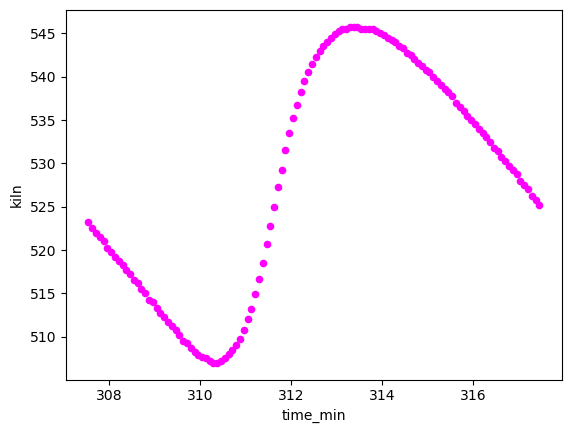

In [39]:
dfl10_min.plot(kind='scatter', x='time_min', y='kiln', color="magenta")

In [40]:
# Fit a linear regression model (degree 1 polynomial)
coefficients = np.polyfit(dfl10_min['time_min'].astype('float'), dfl10_min['kiln'].astype('float'), 1)

# Extract the slope and intercept
slope = coefficients[0]
intercept = coefficients[1]

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

Slope: 2.9507413361113217
Intercept: -394.02387777453197


# all data

<Axes: xlabel='time_min', ylabel='kiln'>

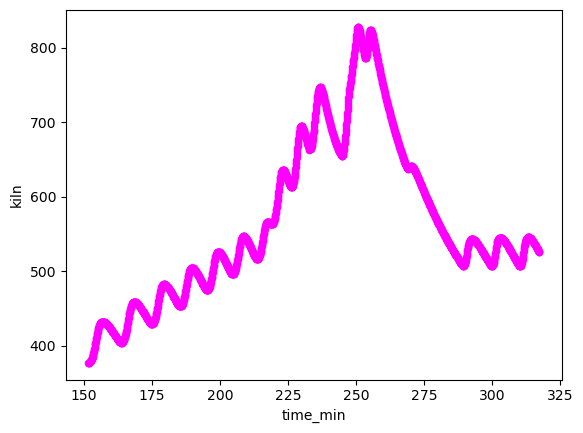

In [41]:
df.plot(kind='scatter', x='time_min', y='kiln', color="magenta")

<Axes: xlabel='time_min', ylabel='housing'>

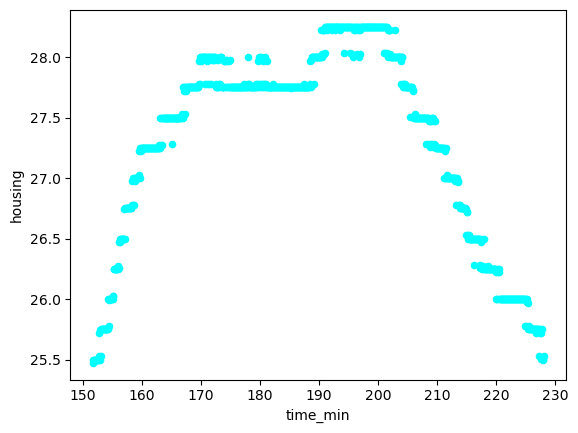

In [32]:
df.plot(kind='scatter', x='time_min', y='housing', color="cyan")